In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Part A

In [ ]:
def compute_charge_density(filename, M=100, L=100.0):
    data = np.loadtxt(filename)
        
    x_p = data[:, 0]
    y_p = data[:, 1]
    
    rho = np.zeros((M, M))
    a = L / M  # Grid spacing
    
    # Coordinates ar e in [0, 100]. Grid indices [0, M-1].
    # Cell i center is at (i + 0.5)*a.
    for k in range(len(x_p)):
        x = x_p[k]
        y = y_p[k]
        
        gx = x / a
        gy = y / a
        
        i = int(gx - 0.5)
        j = int(gy - 0.5)
        
        u = (x/a) - 0.5
        v = (y/a) - 0.5
        
        i_L = int(np.floor(u))
        j_L = int(np.floor(v))
        
        wx_R = u - i_L
        wx_L = 1.0 - wx_R
        
        wy_R = v - j_L
        wy_L = 1.0 - wy_R 
        
        #  boundary conditions (0 to M-1).
        # If particle is at edge, indices might be -1 or M.
        indices_x = [i_L, i_L+1]
        indices_y = [j_L, j_L+1]
        weights_x = [wx_L, wx_R]
        weights_y = [wy_L, wy_R]
        
        for ix, wx in zip(indices_x, weights_x):
            for iy, wy in zip(indices_y, weights_y):
                if 0 <= ix < M and 0 <= iy < M:
                    rho[ix, iy] += wx * wy
                    
    return rho

In [ ]:
filename = 'Files/particles.dat'

rho = compute_charge_density(filename)
print(f"Charge density computed. Grid shape: {rho.shape}, Total Charge: {np.sum(rho):.2f}")

Charge density computed. Grid shape: (100, 100), Total Charge: 24478.00


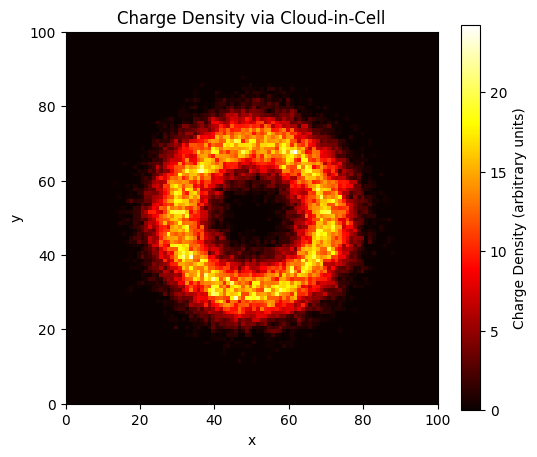

In [ ]:
plt.figure(figsize=(6, 5))
plt.imshow(rho.T, origin='lower', extent=[0, 100, 0, 100], cmap='hot')
plt.colorbar(label='Charge Density (arbitrary units)')
plt.title('Charge Density via Cloud-in-Cell')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Part B

In [ ]:
def solve_poisson(rho, w=1.0, tol=1e-10, max_iter=30000):
    """
    Solves Poisson's equation using SOR (Successive Over-Relaxation).
    If w=1.0, this is the Gauss-Seidel method.
    """
    M = rho.shape[0]
    phi = np.zeros((M+2, M+2))
    
    rho_pad = np.zeros((M+2, M+2))
    rho_pad[1:-1, 1:-1] = rho
    
    y, x = np.indices((M+2, M+2))
    mask = (x + y) % 2
    mask_odd = mask == 1   # i+j is odd
    mask_even = mask == 0  # i+j is even
    
    # Exclude boundaries from updates
    # Feels like a stupid way to do this
    mask_odd[0, :] = False
    mask_odd[-1, :] = False
    mask_odd[:, 0] = False
    mask_odd[:, -1] = False
    mask_even[0, :] = False
    mask_even[-1, :] = False
    mask_even[:, 0] = False
    mask_even[:, -1] = False
    
    delta = 1.0 + tol # Init error
    iters = 0
    
    # Constant coefficient for the source term. Assuming e=1, epsilon0=1, a=1.
    # If units matter, scale rho_pad here.
    source_term = rho_pad
    
    while delta > tol and iters < max_iter:
        phi_old = phi.copy()
        
        neighbors = (phi[0:-2, 1:-1] + phi[2:, 1:-1] + phi[1:-1, 0:-2] + phi[1:-1, 2:])
        phi_gs = 0.25 * (neighbors + source_term[1:-1, 1:-1])
        phi[1:-1, 1:-1][mask_odd[1:-1, 1:-1]] = (1 - w) * phi[1:-1, 1:-1][mask_odd[1:-1, 1:-1]] + w * phi_gs[mask_odd[1:-1, 1:-1]]
            
        neighbors = (phi[0:-2, 1:-1] + phi[2:, 1:-1] + phi[1:-1, 0:-2] + phi[1:-1, 2:])
        phi_gs = 0.25 * (neighbors + source_term[1:-1, 1:-1])
        
        phi[1:-1, 1:-1][mask_even[1:-1, 1:-1]] = (1 - w) * phi[1:-1, 1:-1][mask_even[1:-1, 1:-1]] + w * phi_gs[mask_even[1:-1, 1:-1]]
            
        delta = np.max(np.abs(phi - phi_old))
        iters += 1
        
    return phi[1:-1, 1:-1], iters

In [ ]:

start_time = time.time()
phi_std, iters_std = solve_poisson(rho, w=1.0)
end_time = time.time()

print(f"Standard Relaxation (w=1.0): Converged in {iters_std} iterations.")
print(f"Time taken: {end_time - start_time:.2f} seconds")

Standard Relaxation (w=1.0): Converged in 25173 iterations.
Time taken: 16.44 seconds


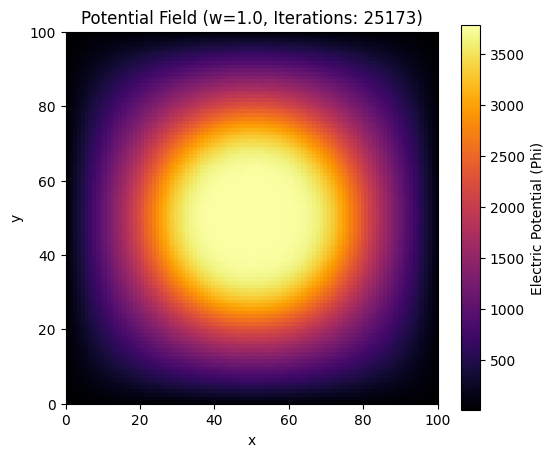

In [49]:
plt.figure(figsize=(6, 5))
plt.imshow(phi_std.T, origin='lower', extent=[0, 100, 0, 100], cmap='inferno')
plt.colorbar(label='Electric Potential (Phi)')
plt.title(f'Potential Field (w=1.0, Iterations: {iters_std})')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Part c

In [50]:
def get_iterations(w_excess, rho, target=1e-10):
    M = rho.shape[0]
    phi = np.zeros((M+2, M+2))
    rho_pad = np.zeros((M+2, M+2))
    rho_pad[1:-1, 1:-1] = rho
    
    w = 1.0 + w_excess
    
    mask = np.indices((M+2, M+2)).sum(axis=0) % 2
    odd = (mask == 1); even = (mask == 0)
    odd[0,:]=False; odd[-1,:]=False; odd[:,0]=False; odd[:,-1]=False
    even[0,:]=False; even[-1,:]=False; even[:,0]=False; even[:,-1]=False
    
    delta = 1.0
    iters = 0
    
    while delta > target:
        phi_old = phi.copy()
        
        neighbors = phi[:-2,1:-1] + phi[2:,1:-1] + phi[1:-1,:-2] + phi[1:-1,2:]
        source = rho_pad[1:-1,1:-1]
        
        phi[1:-1,1:-1][odd[1:-1,1:-1]] = (1-w)*phi[1:-1,1:-1][odd[1:-1,1:-1]] + w*0.25*(neighbors + source)[odd[1:-1,1:-1]]
                                         
        neighbors = phi[:-2,1:-1] + phi[2:,1:-1] + phi[1:-1,:-2] + phi[1:-1,2:]
        
        phi[1:-1,1:-1][even[1:-1,1:-1]] = (1-w)*phi[1:-1,1:-1][even[1:-1,1:-1]] + w*0.25*(neighbors + source)[even[1:-1,1:-1]]
        
        delta = np.max(np.abs(phi - phi_old))
        iters += 1
        
    return iters

In [59]:
phi_ratio = (1 + np.sqrt(5)) / 2
a_brack = 0.5
b_brack = 1
tol = 0.001

c = b_brack - (b_brack - a_brack) / phi_ratio
d = a_brack + (b_brack - a_brack) / phi_ratio

fc = get_iterations(c, rho)
fd = get_iterations(d, rho)

history = []

while abs(b_brack - a_brack) > tol:
    mid = (a_brack + b_brack) / 2
    history.append(mid)
    
    if fc < fd:
        b_brack = d
        d = c
        fd = fc
        c = b_brack - (b_brack - a_brack) / phi_ratio
        fc = get_iterations(c, rho)
    else:
        a_brack = c
        c = d
        fc = fd
        d = a_brack + (b_brack - a_brack) / phi_ratio
        fd = get_iterations(d, rho)

optimal_w = (a_brack + b_brack) / 2
print(f"Optimal w found: {optimal_w:.5f}")

final_iterations = get_iterations(optimal_w, rho)
print(f"Iterations required at optimal w: {final_iterations}")

Optimal w found: 0.94128
Iterations required at optimal w: 492


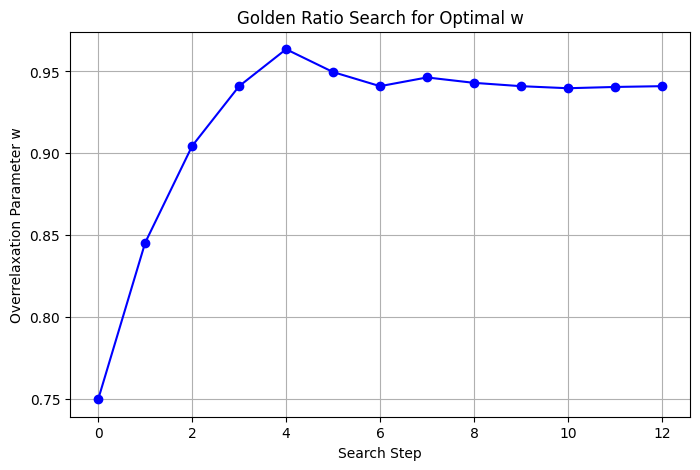

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(history)), history, 'o-', color='b')
plt.xlabel('Search Step')
plt.ylabel('Overrelaxation Parameter w')
plt.title('Golden Ratio Search for Optimal w')
plt.grid(True)
plt.show()